# VizDoom Playground

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import itertools as it
import json
import os
import sys

import cv2
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import vizdoom as vzd

from rlpyt.envs.vizdoom.vizdoom_env import VizDoomEnv
import rlpyt.models.resnet as resnet
from rlpyt.models.dqn.dsr.dsr_model import DsrModel
from rlpyt.models.dqn.dsr.tcf_model import FixedVizDoomModel

vzd_dir = 'vizdoom_data'
import keras
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

from itertools import tee, islice
def nwise(iterable, n=2):                                                      
    iters = tee(iterable, n)                                                     
    for i, it in enumerate(iters):                                               
        next(islice(it, i, i), None)                                               
    return zip(*iters)

np.random.seed(333)
device = torch.device('cuda', index=0)

Using TensorFlow backend.


In [2]:
sptm_model = resnet.ResnetBuilder.build_siamese_resnet_18((6, 120, 160), 2)
sptm_model.load_weights('../../sptm/experiments/0103_R/models/model_weights.h5')
sptm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# SPTM Retrieval Network Features

## Successor Feature Testing

In [3]:
with open('../experiments/configs/fixed-vizdoom.json', 'r') as f:
    config = json.load(f)

In [5]:
config['env']['config'] = '../experiments/vizdoom/train_SPTM.cfg'

In [6]:
env = VizDoomEnv(**config['env'])

In [7]:
# dsr_weights = torch.load('../data/local/20200808/vizdoom/run_3/itr_599999.pkl', map_location=device)
dsr_weights = torch.load('../data/local/20200826/vizdoom/run_32/itr_1249999.pkl', map_location=device)

In [8]:
dsr_model = DsrModel(env.observation_space.shape, env.action_space.n, **config['agent']['model_kwargs'])
dsr_model = dsr_model.to(device=device)

In [9]:
dsr_model.load_state_dict(dsr_weights['agent_state_dict']['model'])
dsr_model.eval()

DsrModel(
  (dsr): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=512, out_features=3584, bias=True)
    )
  )
  (q_estimate): Linear(in_features=512, out_features=1, bias=True)
)

In [20]:
obs = env.reset()

In [21]:
states = []
positions = []

In [22]:
while True:
    state, reward, done, info = env.step(np.random.randint(env.action_space.n))
    states.append(state)
    positions.append(info.position)
    if done:
        break
states = np.array(states)
positions = np.array(positions)

In [23]:
def get_representation(states):
    features = []
    s_features = []
    for state in states:
        feature = sptm_model.layers[3].predict(np.expand_dims(np.transpose(state, [1, 2, 0]), axis=0)).squeeze()
        features.append(feature)
        s_feature = dsr_model(torch.Tensor(feature).unsqueeze(0).to(device), mode='dsr')
        s_features.append(s_feature)
    features = np.array(features)
    s_features = torch.cat(s_features, dim=0)
    return features, s_features

def get_sim(s_features, subgoal_index=0):
    mean_s_features = torch.mean(s_features, dim=1)
    norm_s_features = mean_s_features / torch.norm(mean_s_features, p=2, dim=1, keepdim=True)
    similarities = torch.sum(norm_s_features * norm_s_features[subgoal_index], dim=1)
    return similarities.detach().cpu().numpy()

def get_f_sim(features, subgoal_index=0):
    norm_features = features / np.linalg.norm(features, ord=2, keepdims=True, axis=1)
    similarities = np.sum(norm_features * norm_features[subgoal_index], axis=1)
    return similarities

In [24]:
features, s_features = get_representation(states)

In [25]:
subgoal_index = 1000

In [26]:
sims = get_sim(s_features, subgoal_index)

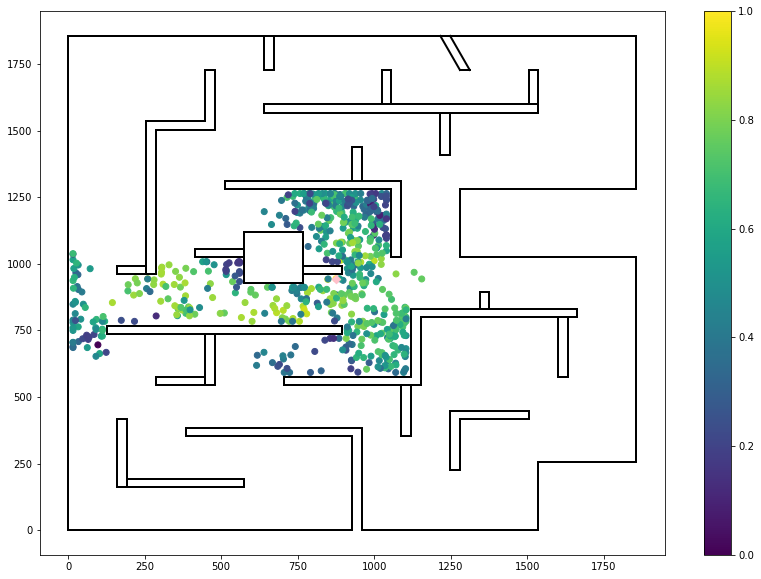

In [27]:
plt.figure(figsize=(14, 10))
env.plot_topdown(objects=False)
plt.scatter(positions[::4, 0], positions[::4, 1], c=sims[::4])
plt.scatter(positions[subgoal_index, 0], positions[subgoal_index, 1], marker='D', c='pink')
plt.colorbar()

In [28]:
f_sims = get_f_sim(features, subgoal_index)

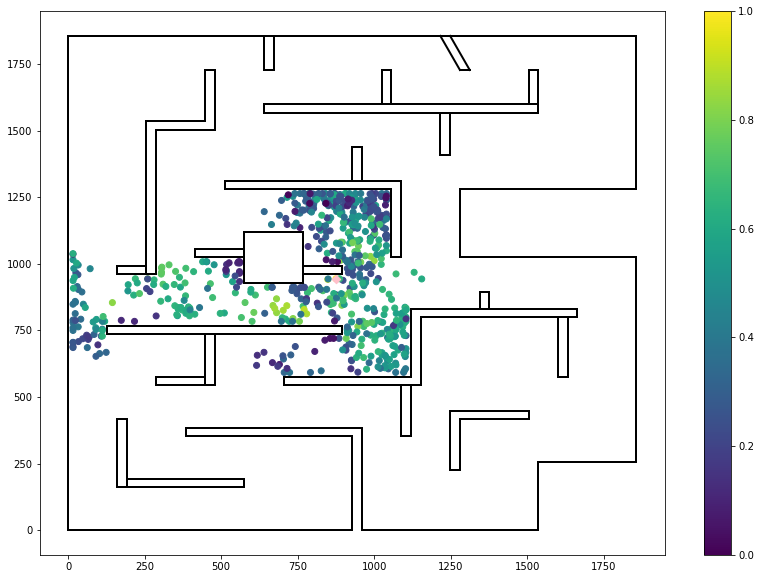

In [29]:
plt.figure(figsize=(14, 10))
env.plot_topdown(objects=False)
plt.scatter(positions[::4, 0], positions[::4, 1], c=f_sims[::4])
plt.scatter(positions[subgoal_index, 0], positions[subgoal_index, 1], marker='D', c='pink')
plt.colorbar()

### Landmarks Testing

In [30]:
mean_s_features = torch.mean(s_features, dim=1)
norm_s_features = mean_s_features / torch.norm(mean_s_features, p=2, dim=1, keepdim=True)

In [31]:
def get_landmarks(s_features, threshold=0.9):
    landmarks = s_features[0:1]
    idxs = [0]
    for i in range(1, len(s_features)):
        cand = s_features[i]
        cand_sim = torch.sum(landmarks * cand, dim=1)
        if sum(cand_sim < threshold) >= len(landmarks):
            landmarks = torch.cat([landmarks, cand.unsqueeze(0)])
            idxs.append(i)
    idxs = np.array(idxs)
    return landmarks, idxs

In [32]:
landmarks, idxs = get_landmarks(norm_s_features, threshold=0.85)

In [33]:
similarity = torch.matmul(landmarks, landmarks.T)

In [54]:
neighbors = torch.topk(similarity, k=4).indices.detach().cpu().numpy()

In [55]:
random_points = np.random.randint(len(neighbors), size=3)

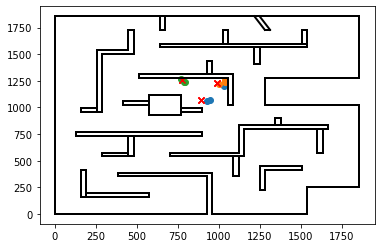

In [56]:
plt.figure()
env.plot_topdown(objects=False)
for point in random_points:
    plt.scatter(positions[neighbors[point, 1:], 0], positions[neighbors[point, 1:], 1])
    plt.scatter(positions[random_points, 0], positions[random_points, 1], marker='x', c='red')

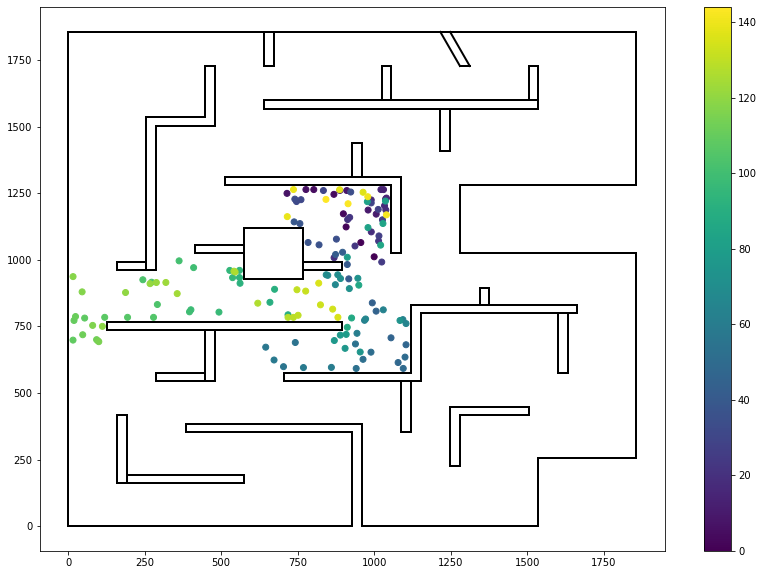

In [37]:
plt.figure(figsize=(14, 10))
env.plot_topdown(objects=False)
plt.scatter(positions[idxs, 0], positions[idxs, 1], c=range(len(idxs)))
plt.colorbar()

### Subgoal Policy

In [57]:
ACTIONS = ['MOVE_LEFT', 'MOVE_RIGHT', 'MOVE_FORWARD', 'MOVE_BACKWARD', 'TURN_LEFT', 'TURN_RIGHT', 'NOOP']
# ACTIONS = ['MOVE_FORWARD', 'MOVE_BACKWARD', 'TURN_LEFT', 'TURN_RIGHT']

In [83]:
HORIZON = 10
num_actions = 20
eps = 0.05
stop_threshold = 0.96

In [84]:
start_idx = np.random.randint(len(states) - 1 - HORIZON) # 126
print(start_idx)
goal_idx = start_idx + HORIZON

865


In [85]:
env.reset()
cur_obs, cur_pos = env.get_obs_at(positions[start_idx])
policy_states = [cur_obs]
policy_pos = [cur_pos]
policy_actions = []
policy_sims = []

In [86]:
for i in range(num_actions):
    cur_s_feature = get_representation([cur_obs])[1].squeeze(0)
    cur_mean_s_feature = cur_s_feature.mean(dim=0)
    cur_norm_mean_s_feature = cur_mean_s_feature / torch.norm(cur_mean_s_feature, p=2, dim=-1, keepdim=True)
    cur_sim = torch.sum(cur_norm_mean_s_feature * norm_s_features[goal_idx])
    policy_sims.append(cur_sim)
    cur_s_feature = cur_s_feature / torch.norm(cur_s_feature, p=2, dim=-1, keepdim=True)
    q_values = torch.sum(cur_s_feature * norm_s_features[goal_idx], dim=-1)
    if np.random.random() < eps:
        action = np.random.randint(env.action_space.n)
    else:
        action = q_values.argmax().item()
    
    policy_actions.append(action)
    cur_obs, _, _, info = env.step(action)
    cur_pos = info.position
    policy_states.append(cur_obs)
    policy_pos.append(cur_pos)
    if cur_sim > stop_threshold:
        print('STOPPED AT ACTION {}'.format(i))
        break
policy_pos = np.array(policy_pos)

STOPPED AT ACTION 16


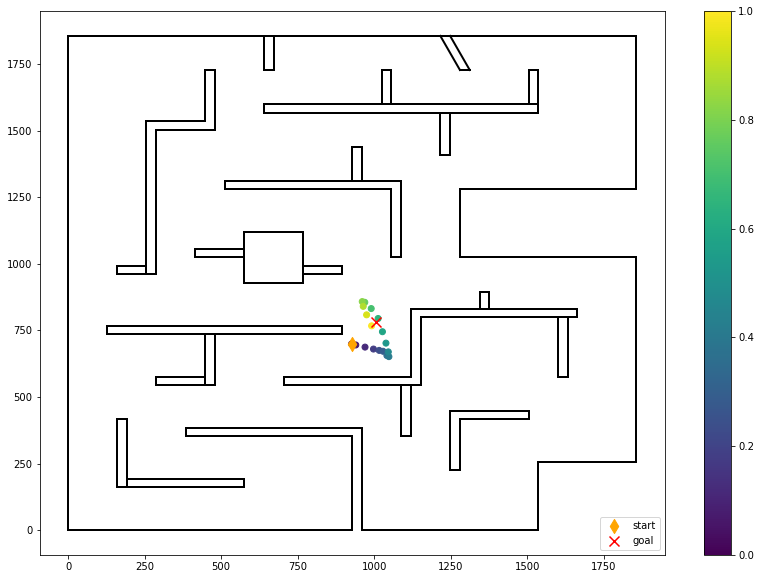

In [96]:
plt.figure(figsize=(14, 10))
env.plot_topdown(objects=False)
plt.scatter(policy_pos[:, 0], policy_pos[:, 1], c=range(len(policy_pos)))
plt.scatter(*positions[start_idx, :2], c='orange', marker='d', label='start', s=100)
plt.scatter(*positions[goal_idx, :2], c='red', marker='x', label='goal', s=100)
plt.legend()
plt.colorbar()

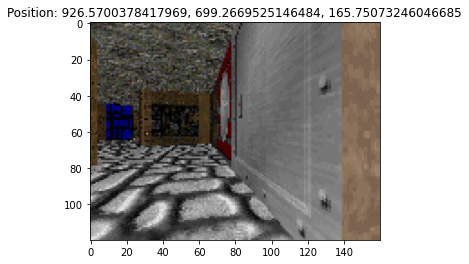

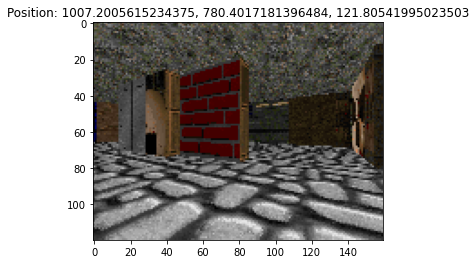

In [90]:
for idx in [start_idx, goal_idx]:
    plt.figure()
    plt.imshow(np.transpose(states[idx], [1, 2, 0]))
    plt.title('Position: {}, {}, {}'.format(*positions[idx]))

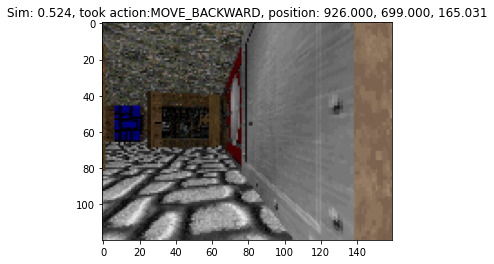

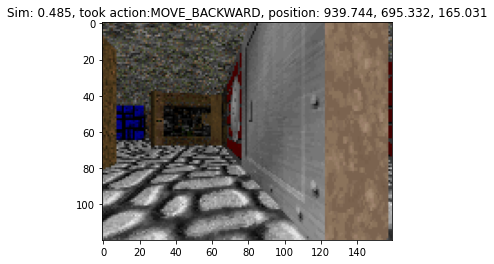

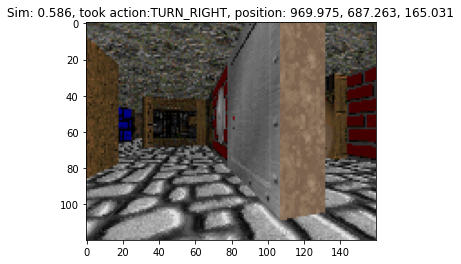

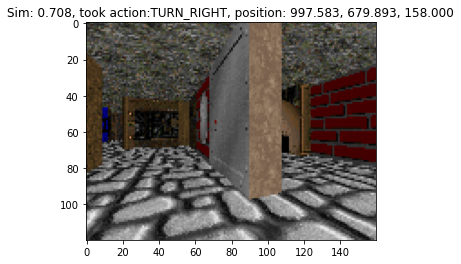

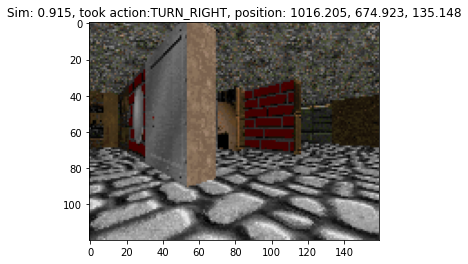

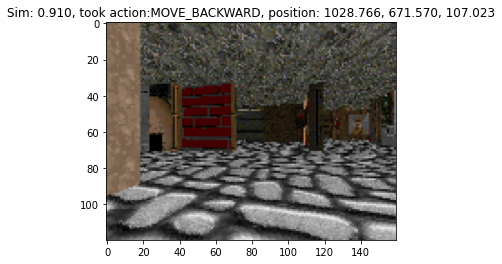

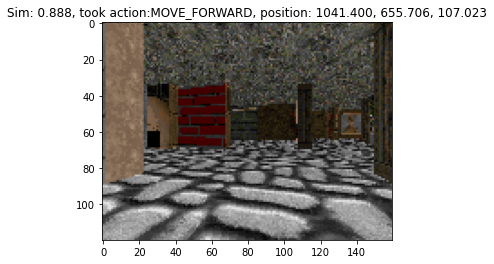

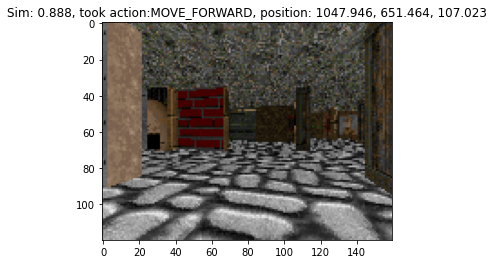

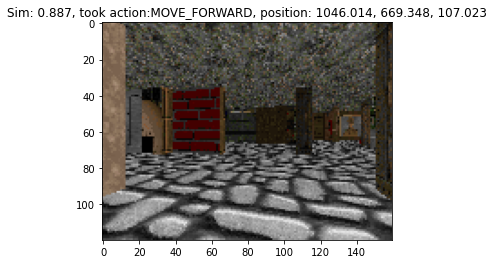

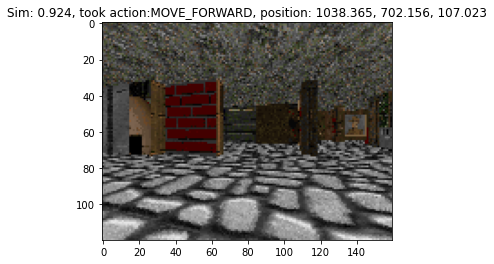

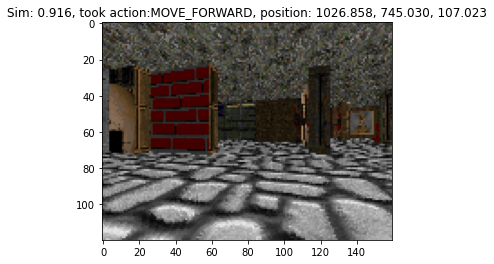

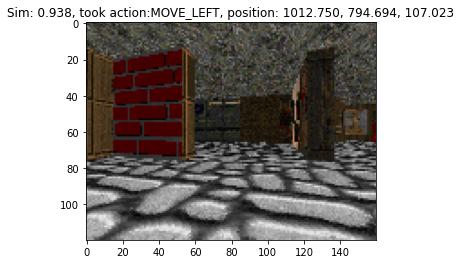

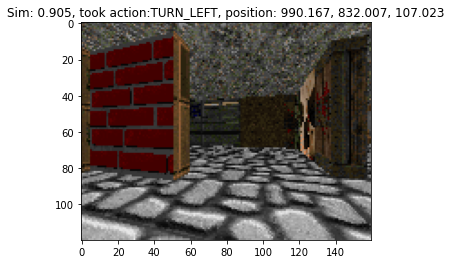

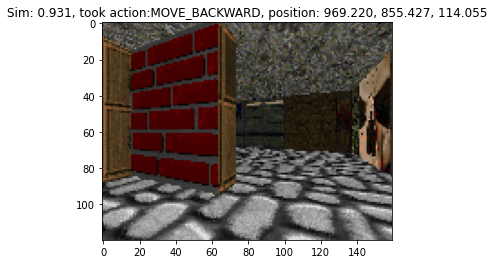

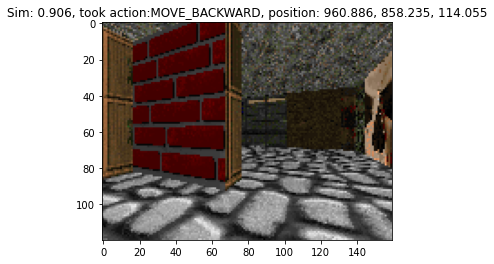

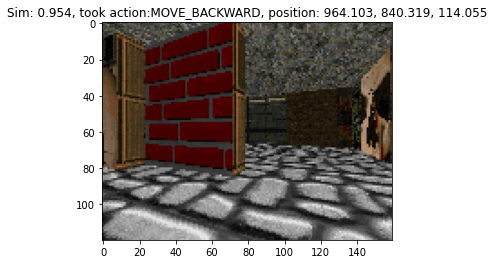

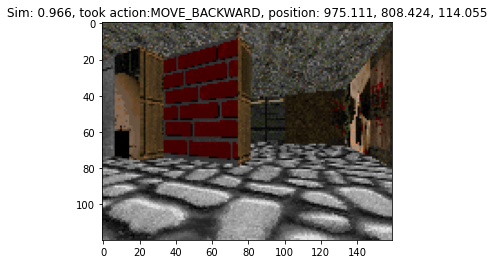

In [91]:
for state, act, sim, pos in zip(policy_states, policy_actions, policy_sims, policy_pos):
    plt.figure()
    plt.imshow(np.transpose(state, [1, 2, 0]))
    plt.title('Sim: {:.3f}, took action:{}, position: {:.3f}, {:.3f}, {:.3f}'.format(sim, ACTIONS[act], *pos))

## Testing SPTM Setup

In [97]:
def check_if_close(first_point, second_point):
    if ((first_point[0] - second_point[0]) ** 2 +
        (first_point[1] - second_point[1]) ** 2 <= GOAL_DISTANCE_ALLOWANCE ** 2):
        return True
    else:
        return False

In [98]:
GOAL_DISTNACE_ALLOWANCE = 63

In [99]:
run = '../data/local/20200826/vizdoom/run_32/'
itr = 1250000

In [100]:
with open('{}/params.json'.format(run), 'r') as f:
    config = json.load(f)
config['env']['config'] = '../experiments/vizdoom/train_SPTM.cfg'

In [101]:
dsr_weights = torch.load('{}/itr_{}.pkl'.format(run, itr - 1), map_location=device)

In [103]:
env = VizDoomEnv(**config['env'])

In [104]:
obs = env.reset()

In [105]:
states = []
positions = []

In [106]:
while True:
    state, reward, done, info = env.step(np.random.randint(env.action_space.n))
    states.append(state)
    positions.append(info.position)
    if done:
        break
states = np.array(states)
positions = np.array(positions)

In [107]:
dsr_model = DsrModel(env.observation_space.shape, env.action_space.n, **config['agent']['model_kwargs'])
dsr_model = dsr_model.to(device=device)

In [108]:
dsr_model.load_state_dict(dsr_weights['agent_state_dict']['model'])
dsr_model.eval()

DsrModel(
  (dsr): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=512, out_features=3584, bias=True)
    )
  )
  (q_estimate): Linear(in_features=512, out_features=1, bias=True)
)

In [109]:
def get_representation(states):
    features = []
    s_features = []
    for state in states:
        feature = sptm_model.layers[3].predict(np.expand_dims(np.transpose(state, [1, 2, 0]), axis=0)).squeeze()
        features.append(feature)
        s_feature = dsr_model(torch.Tensor(feature).unsqueeze(0).to(device), mode='dsr')
        s_features.append(s_feature)
    features = np.array(features)
    s_features = torch.cat(s_features, dim=0)
    return features, s_features

def get_sim(s_features, subgoal_index=0):
    mean_s_features = torch.mean(s_features, dim=1)
    norm_s_features = mean_s_features / torch.norm(mean_s_features, p=2, dim=1, keepdim=True)
    similarities = torch.sum(norm_s_features * norm_s_features[subgoal_index], dim=1)
    return similarities.detach().cpu().numpy()

def get_f_sim(features, subgoal_index=0):
    norm_features = features / np.linalg.norm(features, ord=2, keepdims=True, axis=1)
    similarities = np.sum(norm_features * norm_features[subgoal_index], axis=1)
    return similarities

In [110]:
features, s_features = get_representation(states)

In [111]:
subgoal_index = 1000

In [112]:
sims = get_sim(s_features, subgoal_index)

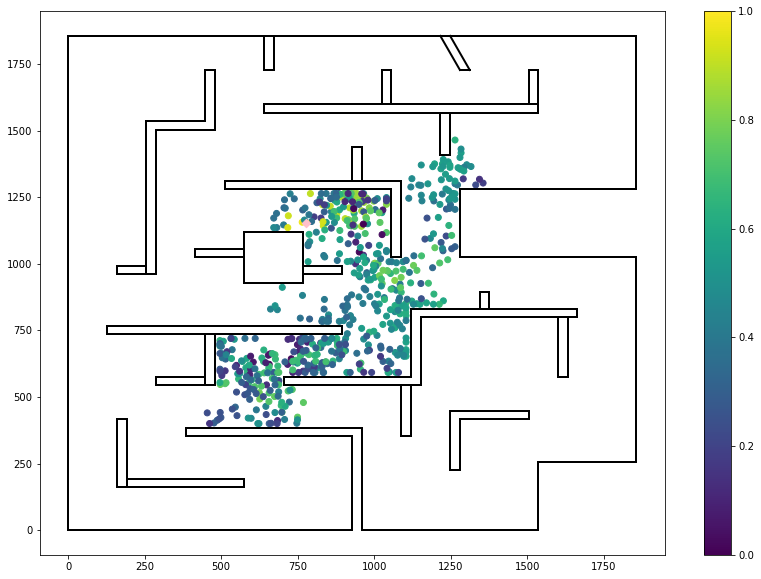

In [113]:
plt.figure(figsize=(14, 10))
env.plot_topdown(objects=False)
plt.scatter(positions[::4, 0], positions[::4, 1], c=sims[::4])
plt.scatter(positions[subgoal_index, 0], positions[subgoal_index, 1], marker='D', c='pink')
plt.colorbar()

In [114]:
mean_s_features = torch.mean(s_features, dim=1)
norm_s_features = mean_s_features / torch.norm(mean_s_features, p=2, dim=1, keepdim=True)

In [115]:
ACTIONS = ['MOVE_LEFT', 'MOVE_RIGHT', 'MOVE_FORWARD', 'MOVE_BACKWARD', 'TURN_LEFT', 'TURN_RIGHT', 'NOOP']

In [218]:
horizon = 10
action_limit = 20
action_limit_threshold = 10
eps = 0.05
stop_threshold = 0.90

In [219]:
env.game.set_episode_timeout(0)
env.game.init()

In [220]:
cur_obs = env.reset()
subgoal_idx = horizon
policy_states = [cur_obs]
policy_pos = [np.array(config['env']['start_position'])]
policy_actions = []
policy_actions_taken = []
reached_subgoals = []
failed_subgoals = []
policy_sims = []
actions_taken = 0
action_limit_count = 0

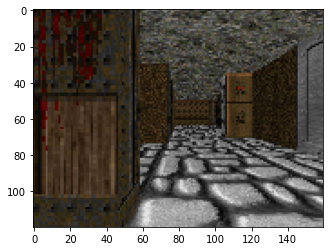

In [221]:
plt.imshow(np.transpose(cur_obs, [1, 2, 0]))

In [222]:
while True:
    cur_s_feature = get_representation([cur_obs])[1].squeeze(0)
    cur_mean_s_feature = cur_s_feature.mean(dim=0)
    cur_norm_mean_s_feature = cur_mean_s_feature / torch.norm(cur_mean_s_feature, p=2, dim=-1, keepdim=True)
    cur_sim = torch.sum(cur_norm_mean_s_feature * norm_s_features[subgoal_idx]).item()
    policy_sims.append(cur_sim)
    cur_s_feature = cur_s_feature / torch.norm(cur_s_feature, p=2, dim=-1, keepdim=True)
    q_values = torch.sum(cur_s_feature * norm_s_features[subgoal_idx], dim=-1)
    if np.random.random() < eps:
        action = np.random.randint(env.action_space.n)
    else:
        action = q_values.argmax().item()
    
    policy_actions.append(action)
    cur_obs, _, _, info = env.step(action)
    actions_taken += 1
    cur_pos = info.position
    policy_states.append(cur_obs)
    policy_pos.append(cur_pos)
    if cur_sim > stop_threshold or actions_taken == action_limit:
        if actions_taken == action_limit:
            print('Reached action limit on subgoal {}'.format(subgoal_idx))
            failed_subgoals.append(subgoal_idx)
            action_limit_count += 1
            if action_limit_count == action_limit_threshold:
                print('Reached action limit threshold')
                break
        else:
            reached_subgoals.append(subgoal_idx)
            action_limit_count = 0
        policy_actions_taken.append(actions_taken)
        if subgoal_idx + horizon > len(norm_s_features):
            break
        subgoal_idx += horizon
        actions_taken = 0

policy_pos = np.array(policy_pos)
policy_sims = np.array(policy_sims)

Reached action limit on subgoal 20
Reached action limit on subgoal 30
Reached action limit on subgoal 90
Reached action limit on subgoal 100
Reached action limit on subgoal 110
Reached action limit on subgoal 120
Reached action limit on subgoal 130
Reached action limit on subgoal 140
Reached action limit on subgoal 150
Reached action limit on subgoal 160
Reached action limit on subgoal 170
Reached action limit on subgoal 180
Reached action limit threshold


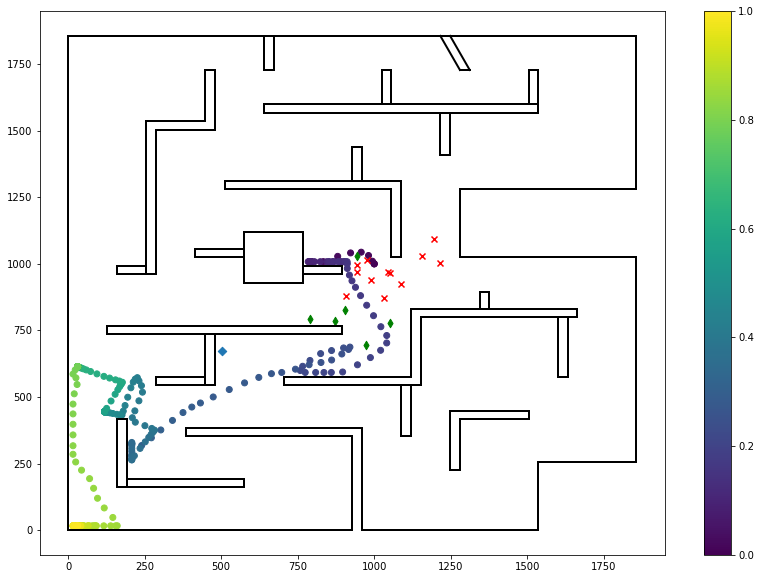

In [223]:
plt.figure(figsize=(14, 10))
env.plot_topdown(objects=False)
plt.scatter(policy_pos[:, 0], policy_pos[:, 1], c=range(len(policy_pos)))
plt.scatter(positions[reached_subgoals, 0], positions[reached_subgoals, 1], c='green', marker='d')
plt.scatter(positions[failed_subgoals, 0], positions[failed_subgoals, 1], c='red', marker='x')
plt.scatter(*positions[-2, :2], marker='D')
plt.colorbar()

# OLD

### Cosine Similarity Testing

In [ ]:
env = VizDoomEnv('../experiments/vizdoom/train_SPTM.cfg', 100, [595, 1200], 270, grayscale=False, map_id='map05')

In [ ]:
sptm_model = resnet.ResnetBuilder.build_siamese_resnet_18((6, 120, 160), 2)
sptm_model.load_weights('../../sptm/experiments/0103_R/models/model_weights.h5')
sptm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
env.set_record_files(['vizdoom_data/test.lmp'])

In [ ]:
obs = env.reset()

In [ ]:
states = []
positions = []
features = []

In [ ]:
while True:
    state, reward, done, info = env.step(np.random.randint(env.action_space.n))
    states.append(state)
    positions.append(info.position)
    if done:
        break
states = np.array(states)
positions = np.array(positions)

In [ ]:
positions[:, 0] *= env.max_x
positions[:, 1] *= env.max_y

In [ ]:
for state in states:
    feature = sptm_model.layers[3].predict(np.expand_dims(np.transpose(state, [1, 2, 0]), axis=0)).squeeze()
    features.append(feature)
features = np.array(features)
norm_features = features / np.linalg.norm(features, ord=2, keepdims=True, axis=1)

In [ ]:
stacked_size = 20
stacked_features = np.array(list(nwise(np.concatenate((features, np.zeros((stacked_size - 1, 512)))), stacked_size)))
stacked_features = stacked_features.reshape(stacked_features.shape[0], -1)
norm_stacked_features = stacked_features / np.linalg.norm(stacked_features, ord=2, keepdims=True, axis=1)

In [ ]:
sequence_length = 20
sequences = np.array(list(nwise(np.concatenate((norm_features, np.zeros((sequence_length - 1, 512)))), sequence_length)))

In [ ]:
compare_idx = 500

In [ ]:
sequence_similarities = np.sum(sequences[compare_idx] * sequences, axis=-1)
similarities = np.median(sequence_similarities, axis=-1)
# similarities = np.sum(norm_stacked_features * norm_stacked_features[compare_idx], axis=1)
# similarities = np.sum(norm_features * norm_features[compare_idx], axis=1)

In [ ]:
high_sim = similarities > 0.90
med_sim = similarities > 0.80
low_sim = similarities > 0.70

In [ ]:
indices = np.arange(len(similarities))[high_sim]
print(indices)
indices = np.arange(len(similarities))[med_sim]
print(indices)
indices = np.arange(len(similarities))[low_sim]
print(indices)

In [ ]:
nearby = range(compare_idx - 10, compare_idx + 10)

In [ ]:
for sim, state, pos in zip(similarities[nearby], states[nearby], positions[nearby]):
    plt.figure()
    plt.imshow(np.transpose(state, [1, 2, 0]))
    plt.title('sim: {}, pos: {}'.format(sim, pos))

In [ ]:
for sim, state, pos in zip(similarities[high_sim], states[high_sim], positions[high_sim]):
    plt.figure()
    plt.imshow(np.transpose(state, [1, 2, 0]))
    plt.title('sim: {}, pos: {}'.format(sim, pos))

In [ ]:
for sim, state, pos in zip(similarities[med_sim], states[med_sim], positions[med_sim]):
    plt.figure()
    plt.imshow(np.transpose(state, [1, 2, 0]))
    plt.title('sim: {}, pos: {}'.format(sim, pos))

In [ ]:
plt.figure(figsize=(10, 10))
env.plot_topdown(objects=False)
plt.scatter(positions[low_sim, 0], positions[low_sim, 1], c='pink', label='Points with similarity > 0.70')
plt.scatter(positions[med_sim, 0], positions[med_sim, 1], c='blue', label='Points with similarity > 0.80')
plt.scatter(positions[high_sim, 0], positions[high_sim, 1], c='green', label='Points with similarity > 0.90')
plt.scatter(positions[compare_idx, 0], positions[compare_idx, 1], c='red', label='Comparison Point')
plt.legend()

In [ ]:
nearby = range(compare_idx - 20, compare_idx + 20)

In [ ]:
plt.figure(figsize=(10, 10))
env.plot_topdown(objects=False)
plt.scatter(positions[nearby, 0], positions[nearby, 1], c='blue')

In [ ]:
plt.figure(figsize=(10, 10))
env.plot_topdown(objects=False)
# plt.scatter(positions[high_sim, 0], positions[high_sim, 1], c='green')
plt.scatter(positions[stacked_high_sim, 0], positions[stacked_high_sim, 1], c='blue')
# plt.scatter(positions[med_sim & ~high_sim, 0], positions[med_sim & ~high_sim, 1])
# plt.scatter(positions[::4, 0], positions[::4, 1], c=similarities[::4])
plt.colorbar()

In [ ]:
plt.figure(figsize=(10, 10))
env.plot_topdown(objects=False)
plt.scatter(positions[:, 0], positions[:, 1], c=np.arange(len(states)))

## MyWayHome

In [ ]:
env = VizDoomEnv('../experiments/vizdoom/my_way_home_SPTM.cfg', 0, [1040, -300], 270, grayscale=False)

In [ ]:
env.plot_topdown()
plt.scatter(env.sample_sectors[:, 0], env.sample_sectors[:, 1], c=env.sample_sectors[:, 2], s=100)

In [ ]:
for state, position in env.sample_states:
    plt.figure(figsize=(7, 7))
    plt.imshow(np.transpose(state, [1, 2, 0]))
    plt.title('{} {}'.format(*position))

In [ ]:
obs = env.reset()

In [ ]:
env.plot_topdown()

In [ ]:
plt.imshow(env.goal_state[-1], cmap='gray')

In [ ]:
env.plot_topdown()

In [ ]:
state = env.state

In [ ]:
state.sectors[0].lines[5].y2

In [ ]:
env.goal_position

In [ ]:
env.game.get_game_variable(vzd.GameVariable.ANGLE)

In [ ]:
env.game.send_game_command("warp 200 -200")

In [ ]:
obs, reward, done, info = env.step(3)

In [ ]:
done

In [ ]:
env.state.game_variables

In [ ]:
plt.imshow(obs[-1], cmap='gray')

In [ ]:
for i in range(500):
    obs, reward, done, info = env.step(np.random.randint(3))
    if done:
        print(reward, i + 1)
        break

In [ ]:
env.plot_topdown()

In [ ]:
plt.imshow(env.visited.T, origin='lower')

## Testing SPTM Retrieval Network

In [ ]:
game = vzd.DoomGame()
game.load_config('vizdoom_data/train_SPTM_control.cfg')
game.set_doom_map('map%02d' % 5)
game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
game.set_mode(vzd.Mode.SPECTATOR)
game.set_seed(100)
game.set_window_visible(True)

In [ ]:
game.init()
game.new_episode()
new_episode = True
while not game.is_episode_finished():
    s = game.get_state()
    if new_episode:
        print(s.game_variables)
        new_episode = False
    game.advance_action()
    a = game.get_last_action()
    r = game.get_last_reward()
game.close()

In [ ]:
env = VizDoomEnv('vizdoom_data/train_SPTM.cfg', 100, [1600, 1500], grayscale=False, map_id=5)

In [ ]:
for state, position in env.sample_states:
    print(position)

In [ ]:
model = resnet.ResnetBuilder.build_siamese_resnet_18((6, 120, 160), 2)

In [ ]:
model.load_weights('../../sptm/experiments/0103_R/models/model_weights.h5')

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
def get_features(state, norm=True):
    model_input = np.expand_dims(np.transpose(state, [1, 2, 0]), 0)
    features = model.layers[3].predict(model_input).squeeze()
    if norm:
        features = features / np.linalg.norm(features, ord=2)
    return features
def get_edge_prediction(A, B):
    concat = np.concatenate((A, B), axis=0)
    model_input = np.expand_dims(np.transpose(concat, [1, 2, 0]), 0)
    return model.predict(model_input)[:, 1]
def get_valid(data, m=3):
    return abs(data - np.mean(data)) < m * np.std(data)

In [ ]:
start_state, start_position = env.get_obs_at((1200, 1000))
start_state_features = get_features(start_state)

In [ ]:
sample_x = np.random.randint(env.min_x, env.max_x, 100)
sample_y = np.random.randint(env.min_y, env.max_y, 100)
samples = []
sample_states = []

In [ ]:
for x, y in zip(sample_x, sample_y):
    state, position = env.get_obs_at((x, y))
    features = get_features(state)
    similarity = np.dot(features, start_state_features)
    prediction = get_edge_prediction(start_state, state).item()
    samples.append((*position, similarity, prediction))
    sample_states.append(state)
samples = np.array(samples)

In [ ]:
env.plot_topdown()
plt.scatter(samples[:, 0], samples[:, 1], c=samples[:, 3], s=81)
plt.scatter(*start_position, marker='D')
plt.colorbar()

## Player Control

In [ ]:
game = vzd.DoomGame()
game.load_config('vizdoom_data/train_SPTM.cfg')
game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
game.set_mode(vzd.Mode.SPECTATOR)
game.set_seed(100)
game.set_doom_map('map05')
game.set_window_visible(True)

In [ ]:
game.init()
game.new_episode()
i = 0
while not game.is_episode_finished():
    s = game.get_state()
#     print('Step {}'.format(i))
    i += 1
    game.advance_action()
    a = game.get_last_action()
    r = game.get_last_reward()
game.close()

## Replay Episode

In [ ]:
game = vzd.DoomGame()
game.load_config('vizdoom_data/my_way_home_control.cfg')
game.init()
game.replay_episode('../data/local/20200722/vizdoom/run_0/eval_run_0_itr_0.lmp')
while not game.is_episode_finished():
    game.advance_action()
game.close()

## Position Prediction Exploration

In [ ]:
np.random.seed(333)

In [ ]:
env = VizDoomEnv('../experiments/vizdoom/train_SPTM.cfg', 100, [595, 1200], 270, grayscale=False, num_samples=20000, map_id='map05')

In [ ]:
model = FixedVizDoomModel('../../sptm/experiments/0103_R/models/model_weights.h5', final_feature_size=2)

In [ ]:
weights = torch.load('../data/local/20200801/vizdoom/run_1/itr_299999.pkl')
model.load_state_dict(weights['agent_state_dict']['feature_model'])

In [ ]:
device = torch.device('cuda', index=0)
model.to(device)

In [ ]:
states = np.stack([state for state, _ in env.sample_states])
positions = np.array([position for _, position in env.sample_states])

In [ ]:
positions[:, 0] = positions[:, 0] / env.max_x
positions[:, 1] = positions[:, 1] / env.max_y

In [ ]:
batch_size = 64
batches = len(states) // batch_size

In [ ]:
diffs = []
for ind in range(batches):
    X = torch.cuda.FloatTensor(states[ind * batch_size: (ind + 1) * batch_size], device=device)
    features = model(X)
    pred_y = model(features, mode='output').detach().cpu().numpy()
    true_y = positions[ind * batch_size: (ind + 1) * batch_size]
    diffs.append(abs(true_y - pred_y))

In [ ]:
diffs = np.concatenate(diffs)

In [ ]:
mean_x = diffs[:, 0].mean()
mean_x

In [ ]:
mean_y = diffs[:, 1].mean()
mean_y

In [ ]:
np.sqrt(mean_x ** 2 + mean_y ** 2)

## Cosine Similarity Exploration

In [ ]:
np.random.seed(333)

In [ ]:
env = VizDoomEnv('../experiments/vizdoom/train_SPTM.cfg', 100, [595, 1200], 270, grayscale=False, map_id='map05')

In [ ]:
env.reset()

In [ ]:
env.state.game_variables

In [ ]:
env.plot_topdown()

In [ ]:
env.sample_states[0][1]

In [ ]:
plt.imshow(np.transpose(env.sample_states[1][0], [1, 2, 0]))

In [ ]:
plt.imshow(np.transpose(env.get_obs_at([595, 1200])[0], [1, 2, 0]))

In [ ]:
positions = np.array([pos for _, pos in env.sample_states])

In [ ]:
env.game.get_state().objects[1].position_y

In [ ]:
env.plot_topdown()
plt.scatter(positions[:, 0], positions[:, 1])

In [ ]:
env.plot_topdown()
plt.scatter(env.sample_sectors[:, 0], env.sample_sectors[:, 1], c=env.sample_sectors[:, 2], s=100)

In [ ]:
start_state = env.sample_states[0]

In [ ]:
start_state_features = start_state[0].flatten() / np.linalg.norm(start_state[0])

In [ ]:
similarities = []

In [ ]:
for state, position in env.sample_states:
    state_features = state.flatten() / np.linalg.norm(state)
    similarity = np.dot(start_state_features, state_features)
    similarities.append((*position, similarity))
#     plt.figure(figsize=(7, 7))
#     plt.imshow(np.transpose(state, [1, 2, 0]))
#     plt.title('{} {}: {}'.format(*position, similarity))

In [ ]:
similarities = np.array(similarities)

In [ ]:
plt.figure(figsize=(7, 7))
env.plot_topdown()
plt.scatter(similarities[:, 0], similarities[:, 1], c=range(len(similarities)), s=100)
plt.colorbar()